# VQQ Lab

In [1]:
# First let's import what we need for our lab first
# uproot High energy physics python file format => https://masonproffitt.github.io/uproot-tutorial/aio.html
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os,sys

#plotting style for High Energy physics 
import lmfit as lm
import mplhep as hep
plt.style.use(hep.style.CMS)

### Loading the data

Here is some codes to load the correct data sets!

In [2]:
# Now lets look at the data. Our data sample is the JetHT dataset. 
# What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data   = uproot.open("data/JetHT_s.root")["Tree"]

# In addition to above we have Monte Carlo Simulation of many processes
# Some of these process are well modelled in simulation and some of them are not
#-------------------------------------------------------------------------------

# Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq    = uproot.open("data/WQQ_s.root")["Tree"]

# Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq    = uproot.open("data/ZQQ_s.root")["Tree"] 

#Hint: You could check for files in the data directory by doing "!ls data/" in a cell.
#The ZQQ file name is similar to WQQ

# Unfortunately the samples I made above a long time ago are very small. 
# To train NNs and make nice plots we will use larger samples produced at a different collision energy
# qq=>W=>qq at 13TeV collision energy
wqq13  = uproot.open("data/skimh/WQQ_sh.root")["Tree"]

# qq=>Z=>qq at 13TeV collision energy
zqq13  = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]

# Now we have our worst modeled background this is also our main background. 
# This is is our di-jet quark and gluon background. 
# We just call these backgrounds QCD because they are produced with Quantum Chromo Dynamics. 
qcd    = uproot.open("data/QCD_s.root")["Tree"]

# Now we have the Higgs boson sample (we might need this in the future)
ggh    = uproot.open("data/ggH.root")["Tree"]

# And top-quark pair production background. 
tt     = uproot.open("data/TT.root")["Tree"]

# Finally we have the rarer double W, W+Z and Z+Z diboson samples where we have two bosons instead of one
ww     = uproot.open("data/WW.root")["Tree"]
wz     = uproot.open("data/WZ.root")["Tree"]
zz     = uproot.open("data/ZZ.root")["Tree"]

## Simple helper functions

After loading the data, you are provided with some simple helper functions that have already been used in our introduction notebook. These are used for pre-selection (standard cuts that physicsists usually apply before making measurements) and computing the scaling factor of datasets. You can review the previous notebook for further explanations!

In [3]:
def selection(iData):
    '''
    Standard pre-selection
    '''
    #lets apply a trigger selection
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)

    #Now lets require the jet pt to be above a threshold (400 TODO: ASK about units)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)

    #Lets apply both jetpt and trigger at the same time
    #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
    allcuts = np.logical_and.reduce([trigger,jetpt])

    return allcuts
    
def get_weights(iData,weights,sel):
    
    weight = weights[0]
    
    for i in range(1,len(weights)):
        weight *= iData.arrays(weights[i],library="np")[weights[i]][sel]
        
    return weight

def integral(iData,iWeights):
    '''
    This computs the integral of weighted events 
    assuming a selection given by the function selection (see below)
    '''
    
    #perform a selection on the data (
    mask_sel=selection(iData)
    
    #now iterate over the weights not the weights are in the format of [number,variable name 1, variable name 2,...]
    weight  =iWeights[0]
    
    for i0 in range(1,len(iWeights)):
        weightarr = iData.arrays(iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        
        #multiply the weights
        weight    = weight*weightarr
    
    #now take the integral and return it
    return np.sum(weight)


def scale(iData8TeV,iData13TeV,iWeights):
    '''
    This computes the integral of two selections for two datasets labelled 8TeV and 13TeV,
    but really can be 1 and 2. Then it returns the ratio of the integrals
    '''
    
    int_8TeV  = integral(iData8TeV,iWeights)
    int_13TeV = integral(iData13TeV,iWeights)
    
    return int_8TeV/int_13TeV

-----

# 1. Fit for W Peak

Now, lets do the lab. <font color="blue"> Your first challenge is to make a mass plot and perform fitting for W signal. </font>. A hint is that the plots should come out like this, where on the left we show the soft-drop mass/groomed mass ($m_{SD}$) distribution for different processes in the Monte Carlo simulation along with the real data. The plot on the right shows the fit: 
<img src="images/S50_WFit.png" width='900'>

First I will walk you through the fit for W, and then you will have the chance to do the Z fit for yourself:

-----

## 1.1 W Mass Plot

To make the mass plot and perform fitting, the most important function is our signal selection function, where in addition to the standard selections (such as trigger and transverse momentum selections) we need to perform other selections in order to increase the amount of events with W in our sample.

Your first assignment is thus to complete the function below, notice that the standard pre-selection is already given to you. The specific cuts are performed according to this paper:

https://arxiv.org/pdf/1603.00027.pdf

Your task is to figure out how the two parameters: $\rho$ and $\tau_2/\tau_1$ are defined by quoting the paper. And then make a selection based on these parameters for the $W$.

A hint to determine the cut is to plot the distribution of the scores like this (plot taken from [this paper](https://arxiv.org/pdf/1410.4227.pdf) ):

<img src="images/S50_Wt21Cut.png" width='400'>

Looking at the plot, how would you determine a cut to best select out the W signal?

In [ ]:
def selectionW(iData):
    '''
    This is the specific selection for selecting out events with W signal for our analysis
    '''
    
    #Pre-selection citeria
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
    
    #Define the two parameters rho and tau2/tau1 according to the paper
    #Hint: Use 'vjet0_msd0' for mass and 'vjet0_pt' for pt
    rho = #### YOUR CODE HERE ####
    
    #Hint: tau2 and tau1 are already given in the data set as 'vjet0_t2' and 'vjet0_t1'. 
    #Computing their ratio is straight-forward.
    t21 = #### YOUR CODE HERE ####
    
    #Now compute their DDT (Designing Decorrelated Taggers) score.
    #0.065 is mostly a number that has been pre-selected,
    #rho here is mostly a variable so that we could include mass
    
    t21ddt = t21 + .065*rho 
                            
    #And then perform the cut
    #Hint: You could determine the threshold of the cut by plotting the distribution of 
    #t21ddt scores for W and background and then determine a ball park threshold
    #where you think the W signal would be best selected
    #Or more simply you could look at the given plot and determine the appropriate threshold.
    
    t21cut   = t21ddt < #### YOUR CUT HERE #####
    
    allcuts = np.logical_and.reduce([trigger, jetpt, t21cut])
    
    return allcuts

### Solution

In [ ]:
def selectionW(iData):
    '''
    This is the specific selection for selecting out events with W signal for our analysis
    '''
    
    #Pre-selection citeria
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
    jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
    
    #Define the two parameters rho and tau2/tau1 according to the paper
    #Hint: Use 'vjet0_msd0' for mass and 'vjet0_pt' for pt
    rho = np.log(iData.arrays('vjet0_msd0',library="np")["vjet0_msd0"]**2/iData.arrays('vjet0_pt',library="np")["vjet0_pt"])
    
    #Hint: tau2 and tau1 are already given in the data set as 'vjet0_t2' and 'vjet0_t1'. 
    #Computing their ratio is straight-forward.
    t21 = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"]/
           iData.arrays('vjet0_t1', library="np")["vjet0_t1"])
    
    #Now compute their DDT (Designing Decorrelated Taggers) score.
    #0.065 is mostly a number that has been pre-selected,
    #rho here is mostly a variable so that we could include mass
    
    t21ddt = t21 + .065*rho 
                            
    #And then perform the cut
    #Hint: You could determine the threshold of the cut by plotting  
    #Or you could look at the given plot and determine the appropriate threshold.
    
    t21cut   = t21ddt < .4
    
    allcuts = np.logical_and.reduce([trigger, jetpt, t21cut])
    
    return allcuts

-----

Great! now that we have our selection function, let's try to make the mass plot!

Hint: This code assignment is straight forward so don't over think it, we just want to make sure you are following evrything.

In [ ]:
#Lets Look at the mass
weights = [1000*18300, "puweight", "scale1fb"]
mrange = (45,200)  #range for mass histogram [GeV]
bins=40            #bins for mass histogram
density = True     #to plot the histograms as a density (integral=1)

qcdsel      = selectionW(qcd)
wsel        = selectionW(wqq13)
zsel        = #### YOUR CODE HERE ####
datasel     = selectionW(data)
ttsel       = selectionW(tt)
wwsel       = #### YOUR CODE HERE ####
wzsel       = selectionW(wz)
zzsel       = selectionW(zz)
gghsel      = selectionW(ggh)


wscale=scale(wqq,wqq13,weights)
zscale=#### YOUR CODE HERE ####

# Getting the masses of selected events
dataW = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdW = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wW = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zW = #### YOUR CODE HERE ####
zzW = #### YOUR CODE HERE ####
wzW = #### YOUR CODE HERE ####
wwW = #### YOUR CODE HERE ####
ttW = #### YOUR CODE HERE ####
gghW = #### YOUR CODE HERE ####

#Define the weights for the histograms
hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                #### YOUR CODE HERE ####,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

#Hint: Provide a list of selected data
plt.hist(#### YOUR CODE HERE ####, 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan",], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt",], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)

#Other configurations for the histogram
counts, bins = np.histogram(dataW, bins=bins, range=mrange, density=density)
yerr = np.sqrt(counts) / np.sqrt(len(dataW)*np.diff(bins))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

### Solution

/uscms_data/d3/dhoang/miniconda3/envs/env_S50/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


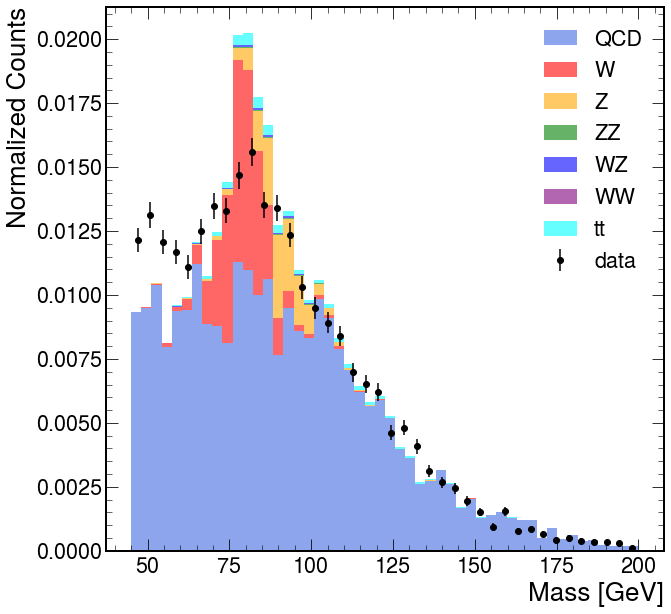

In [17]:
#Lets Look at the mass
weights = [1000*18300, "puweight", "scale1fb"]
mrange = (45,200)  #range for mass histogram [GeV]
bins=40            #bins for mass histogram
density = True     #to plot the histograms as a density (integral=1)

qcdsel      = selectionW(qcd)
wsel        = selectionW(wqq13)
zsel        = selectionW(zqq13)
datasel     = selectionW(data)
ttsel       = selectionW(tt)
wwsel       = selectionW(ww)
wzsel       = selectionW(wz)
zzsel       = selectionW(zz)
gghsel      = selectionW(ggh)
wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

dataW = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdW = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wW = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zW = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzW = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzW = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwW = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttW = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gghW = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

plt.hist([qcdW,wW, zW, zzW, wzW, wwW, ttW], 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan",], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt",], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)

counts, bins = np.histogram(dataW, bins=bins, range=mrange, density=density)
yerr = np.sqrt(counts) / np.sqrt(len(dataW)*np.diff(bins))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

-------

Remember to compare your mass plot with the plot given above to make sure it gives the correct distribution!

## 1.2 W Peak Fit

In this section you will perform the fit on W signal. It involves a few steps:
    
1. First you need to define a fit model of your own. In this case we would use a gaussian defined on top of a 6th order polynomial. You could see more on how the order of the polynomials are determined here: https://en.wikipedia.org/wiki/Chow_test. The concepts were also covered in Lecture 8-9 if you want to review it. Later on you will have the chance to determine the order of the polynomial for the Z fit. You might see that we might not necessarily need a 6th order polynomial for the Z fit. The main reason for this is that we have much more data in W sample than the Z sample.

In [6]:
def polgaus2(x, p0, p1, p2, p3, p4, p5, a, mu, sigma):
    '''
    Our model is a gaussian on top of 6th order polynomial.
    '''
    
    #Define the polynomial
    pols=[p0, p1, p2, p3, p4, p5]
    poly  = np.polyval(pols,x)
    
    #Define the gaussian
    gauss = #### YOUR CODE HERE ####
    
    #Stick them together
    y =  poly + a*gauss
    
    return y

### Solution

In [6]:
def polgaus2(x, p0, p1, p2, p3, p4, p5, a, mu, sigma):
    '''
    Our model is a gaussian on top of 6th order polynomial.
    '''
    
    #Define the polynomial
    pols=[p0, p1, p2, p3, p4, p5]
    poly  = np.polyval(pols,x)
    
    #Define the gaussian
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    
    #Stick them together
    y =  poly + a*gauss
    
    return y

------

2. After defining your model, you need to get the data histogram and perform the fit, here I give you an example on how to perform the W fit, you will have the chance to adapt this for your Z fit later on.

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 28
    # variables        = 9
    chi-square         = 30.0641333
    reduced chi-square = 1.58232281
    Akaike info crit   = 19.9915943
    Bayesian info crit = 31.9814349
[[Variables]]
    p0:    -2.5070e-12 +/- 6.3705e-13 (25.41%) (init = -3.343897e-12)
    p1:     1.5407e-09 +/- 4.3800e-10 (28.43%) (init = 2.133232e-09)
    p2:    -3.5097e-07 +/- 1.1684e-07 (33.29%) (init = -5.133544e-07)
    p3:     3.6461e-05 +/- 1.4978e-05 (41.08%) (init = 5.776477e-05)
    p4:    -0.00179843 +/- 9.0795e-04 (50.49%) (init = -0.003111808)
    p5:     0.04605792 +/- 0.02014316 (43.73%) (init = 0.07536875)
    a:      0.00422418 +/- 6.7111e-04 (15.89%) (init = 0.005048661)
    mu:     82.6970568 +/- 1.25927413 (1.52%) (init = 80)
    sigma:  9.70737799 +/- 1.71554412 (17.67%) (init = 11.70122)
[[Correlations]] (unreported correlations are < 0.100)
    C(p4, p5)    

30.064133346555906

<Figure size 720x720 with 0 Axes>

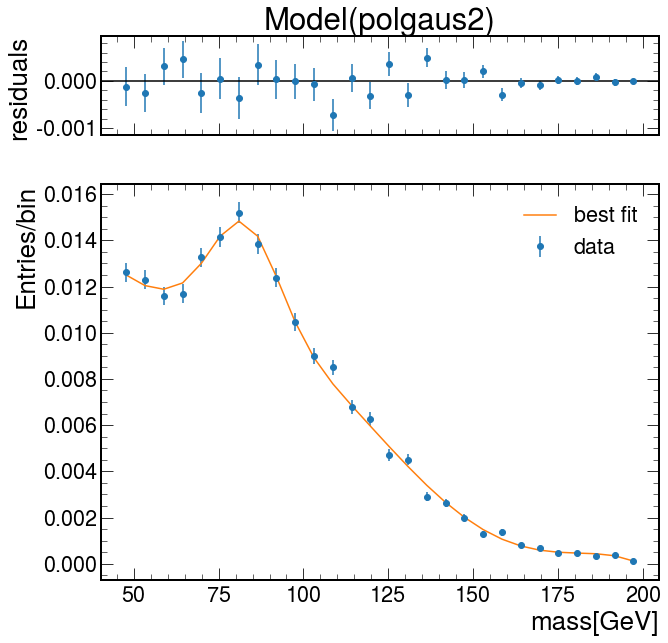

In [7]:
# Now we get the data histogram so we can fit it
bins = 28
counts, bins = np.histogram(dataW,
                            bins=bins,
                            range=mrange,
                            density=True)

yvar = counts/len(dataW)/np.diff(bins)
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

#Perform the fit 
model = lm.Model(polgaus2,)
p = model.make_params(p0=-3.3438965886446737e-12,
                      p1=2.1332319456288657e-09,
                      p2=-5.133544460851947e-07, 
                      p3=5.776476610767709e-05,
                      p4=-0.0031118077091850833,
                      p5=0.07536875031296641, 
                      a=0.005048661046674717,
                      mu=80,
                      sigma=11.701217273469597,)

result_W = model.fit(data=y,
                   params=p,
                   x=x,
                   weights=w,
                   method="leastsq")

#Plot the result
plt.figure()
result_W.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))

#Print the fit summary
print(result_W.fit_report())
result_W.chisqr

Remember to compare your fit plot! Now we need to extract the W mass and the error in the measurement!

In [ ]:
mW = #### YOUR CODE HERE ####
mWerr = #### YOUR CODE HERE ####

You should obtain the following results:
    
- $m_W \approx 82.697$ GeV
- $m_W (error) \approx ~1.259$ GeV

### Solution

In [8]:
mW = result_W.params["mu"].value
mWerr = result_W.params["mu"].stderr

----

# 2. Fit for Z peak

Now that you have done the W fit, the next challenge is to see whether you can also perform the Z fit! They are very similar in concepts. However, the selection for Z requires a special cut: **the deep double-b tagging score (ddb).** This is because unlike the W, Z can decays into two b quarks and hence a cut on this score would remove many W signals. 

The codes to perform the fit should be very similar to what we have shown you in the last section! Your plots should come out like this in the end:

<img src="images/S50_ZFit.png" width='900'>

First, let's try to re-write the selection function. Remember that you now need to add the deep double b score of the jet and place a cut on it. The inividual b score in each subjet is already given in the `vjet0_sj1_csv` and `vjet0_sj2_csv` variable, how would you compute the b score of the whole jet?

Another hint for placing the cut is this following table: 

<img src="images/S50_ZBtagCut.png" width='500'>

You could just ignore the labelling for the most part, the main point here is that there are three "operating" or "working" points: tight, medium, loose. Each according to specific cuts on the **individual** subjet b score. For example, a mistag rate of 0.1 would require the b score to be more than 0.9. The tight working point is also what is generally used. Using this information could you pick an appropriate threshold for the whole jet?

In [1]:
# Let's define a selection that will keep Z jets and remove background.
def selectionZ(iData):
    
        #Standard preselection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
        
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
        
        # Following the same procedure as https://arxiv.org/pdf/1603.00027.pdf
        # we select 2 progned jets (since W and Z primarily decay to 2 quarks)
        # we correct t21 to minimize the dependance on m and pt
        rho = #### YOUR CODE HERE ####
        t21 = #### YOUR CODE HERE ####
        
        t21ddt = t21+.05*rho
        t21cut   = t21ddt < .62
        
        # this cut keeps jets with subjet 1 and subjet 2 coming from a secondary vertex
        # i.e. the subjets originate from a displaced particle (namely a b quark)
        # Unlike W bosons, the Z can decay into 2 b quarks which is why this selection removes 
        # many W jets.
        
        ddb= #### YOUR CODE HERE ####
        ddbcut = ddb >= #### YOUR CUT HERE ####
        
        allcuts = np.logical_and.reduce([trigger,jetpt, t21cut, ddbcut])
        
        return allcuts

### Solution

In [1]:
# Let's define a selection that will keep Z jets and remove background.
def selectionZ(iData):
    
        #Standard preselection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
        
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
        
        # Following the same procedure as https://arxiv.org/pdf/1603.00027.pdf
        # we select 2 progned jets (since W and Z primarily decay to 2 quarks)
        # we correct t21 to minimize the dependance on m and pt
        rho = np.log(iData.arrays('vjet0_msd0',library="np")["vjet0_msd0"]**2/iData.arrays('vjet0_pt',library="np")["vjet0_pt"])
        t21 = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"]/
               iData.arrays('vjet0_t1', library="np")["vjet0_t1"])
        t21ddt = t21+.05*rho
        t21cut   = t21ddt < .62
        
        # this cut keeps jets with subjet 1 and subjet 2 coming from a secondary vertex
        # i.e. the subjets originate from a displaced particle (namely a b quark)
        # Unlike W bosons, the Z can decay into 2 b quarks which is why this selection removes 
        # many W jets.
        
        ddb=iData.arrays("vjet0_sj1_csv", library="np")["vjet0_sj1_csv"]+iData.arrays("vjet0_sj2_csv", library="np")["vjet0_sj2_csv"]
        ddbcut = ddb >= 1.85
        
        allcuts = np.logical_and.reduce([trigger,jetpt, t21cut, ddbcut])
        
        return allcuts

Similar to the W, let's try to make the mass plot first to see if we get the correct mass plot:

## 2.1 Z mass plot

We can basically just reused what we had in the last section

/uscms_data/d3/dhoang/miniconda3/envs/env_S50/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


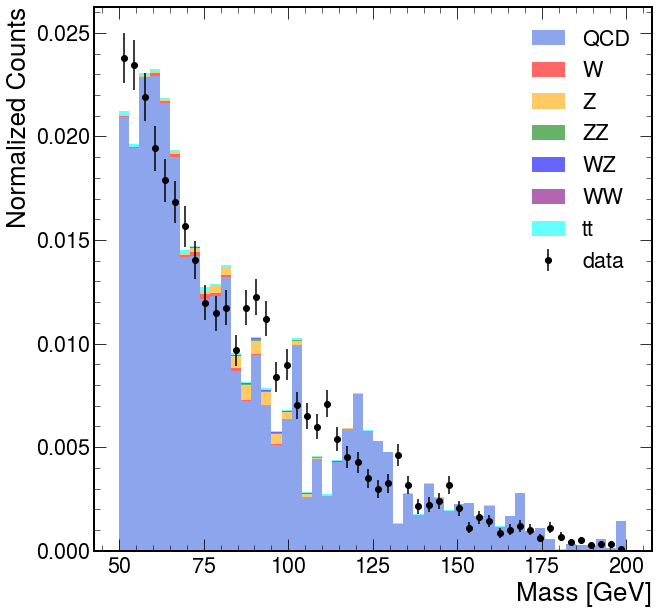

In [10]:
# Some default parameters
weights=[1000*18300,"puweight","scale1fb"]
mrange = (50,200) #range for mass histogram [GeV]
bins=50           #bins for mass histogram
density = True    #to plot the histograms as a density (integral=1)

# Selecting data and MC 
qcdsel      = selectionZ(qcd)
wsel        = selectionZ(wqq13)
zsel        = selectionZ(zqq13)
datasel     = selectionZ(data)
ttsel       = selectionZ(tt)
wwsel       = selectionZ(ww)
wzsel       = selectionZ(wz)
zzsel       = selectionZ(zz)
gghsel      = selectionZ(ggh)

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

# Getting the masses of selected events
datat21 = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdt21 = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wt21 = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zt21 = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzt21 = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzt21 = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwt21 = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttt21 = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gght21 = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

# Proper weights for each histogram
hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale,
                get_weights(zz,weights,zzsel),
                get_weights(wz,weights,wzsel),
                get_weights(ww,weights,wwsel),
                get_weights(tt,weights,ttsel),
               ]

# Plot stacked histograms
plt.hist([qcdt21,wt21, zt21, zzt21, wzt21, wwt21, ttt21], 
         color=["royalblue","r", "orange","g", "b", "purple", "cyan"], 
         label=["QCD", "W", "Z", "ZZ", "WZ", "WW", "tt"], 
         weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)
counts, bins = np.histogram(datat21,bins=bins,range=mrange,density=density)

# Getting the proper err requires normalizing since we are using a density not the actual count
yerr = np.sqrt(counts) / np.sqrt(len(datat21)*(np.diff(bins))) 
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

Make sure to compare your mass plot with the plot given above!

## 2.1 Fit for Z peak

Now, adapting the codes provided for you in the W section, perform a fit to the Z peak and extract its mass! The concept is similar to our previous W fit, but this time I would let you explore what fit function would be appropriate in this case.

In [ ]:
def polgaus():
    '''
    Gaussian on 5th order polynomials!
    '''
    
    
    return y

### Solution

In [11]:
def polgaus(x, p0, p1, p2, p3, p4, a, mu, sigma):
    '''
    Gaussian on 5th order polynomials!
    '''
    pols=[p0, p1, p2, p3, p4]
    poly  = np.polyval(pols,x)
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    y =  poly + a*gauss
    
    return y

----

Then, get the data histogram and perform the fit

In [ ]:
# Now we get the data histogram so we can fit it
counts, bins = np.histogram(#### YOUR CODE HERE ####
                            bins=40,
                            range=mrange,
                            density=True)

yvar = #### YOUR CODE HERE ####
w = #### YOUR CODE HERE ####
binCenters = #### YOUR CODE HERE ####
x,y = #### YOUR CODE HERE ####

### Solution

In [12]:
# Now we get the data histogram so we can fit it
counts, bins = np.histogram(datat21,
                            bins=40,
                            range=mrange,
                            density=True)

yvar = counts/len(datat21)/np.diff(bins) 
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

-------

In [ ]:
#Perform the fit
model = lm.Model(polgaus)
p = model.make_params(p0=-2.9898e-09,
                      p1=2.0335e-06,
                      p2=-4.6726e-04,
                      p3=0.03619398,
                      p4=-.01,
                      p5=.01,
                      a=1,
                      b=-0.00188134,
                      lambd=1,
                      mu=92,
                      sigma=2.5)


result_Z = #### YOUR CODE HERE ####

#Plottting
plt.figure()
result_Z.plot()
plt.xlabel("mass[GeV]", position=(0.92,0.1))
plt.ylabel("Entries/bin", position=(0.1,0.84))

#We could also check out all the fit parameters
print(result_Z.fit_report())

### Solution

[[Model]]
    Model(polgaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 40
    # variables        = 8
    chi-square         = 43.2866042
    reduced chi-square = 1.35270638
    Akaike info crit   = 19.1585504
    Bayesian info crit = 32.6695860
[[Variables]]
    p0:     7.5589e-11 +/- 3.2204e-11 (42.60%) (init = -2.9898e-09)
    p1:    -4.9824e-08 +/- 1.7745e-08 (35.62%) (init = 2.0335e-06)
    p2:     1.2717e-05 +/- 3.5263e-06 (27.73%) (init = -0.00046726)
    p3:    -0.00153228 +/- 2.9628e-04 (19.34%) (init = 0.03619398)
    p4:     0.07555856 +/- 0.00873846 (11.57%) (init = -0.01)
    a:      0.00294296 +/- 8.6600e-04 (29.43%) (init = 1)
    mu:     91.3761861 +/- 1.07883553 (1.18%) (init = 92)
    sigma:  3.40427359 +/- 1.17352988 (34.47%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.998
    C(p1, p2)    = -0.997
    C(p2, p3)    = -0.997
    C(p3, p4)    = -0.994
    C(p0, 

<Figure size 720x720 with 0 Axes>

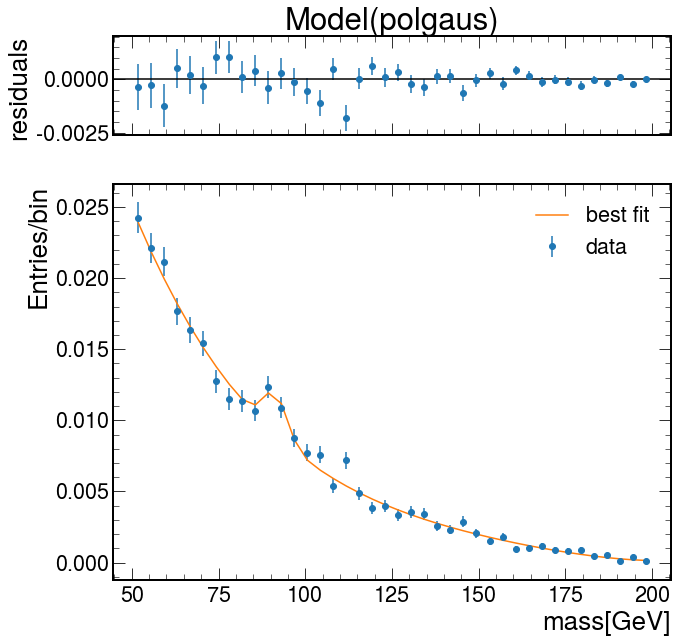

In [13]:
model = lm.Model(polgaus)
p = model.make_params(p0=-2.9898e-09,
                      p1=2.0335e-06,
                      p2=-4.6726e-04,
                      p3=0.03619398,
                      p4=-.01,p5=.01,
                      a=1,
                      b=-0.00188134,
                      lambd=1,
                      mu=92,
                      sigma=2.5)


result_Z = model.fit(data=y, params=p, x=x, weights=w)

#Plottting
plt.figure()
result_Z.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))

#We could also check out all the fit parameters
print(result_Z.fit_report())

------

After the fit we can extract the Z mass and the error in our measurement

In [ ]:
mZ = #### YOUR CODE HERE ####
mZerr = #### YOUR CODE HERE ####

You should obtain the following results:
    
- $m_Z \approx 91.373$ GeV
- $m_Z (error) \approx ~1.348$ GeV

### Solution

In [14]:
mZ = result_Z.params["mu"].value
mZerr = result_Z.params["mu"].stderr

-----

# 3. Weak mixing angle

If you have both W and Z boson, you can measure a fundamental parameter of the standard model. The Weak mixing angle, sometimes referred to as the Weinberg angle. 

<font color="blue"> From your measurement of the W and Z boson mass come up with a measurement of the W and Z boson mixing angle.  </font>

we have that $\sin^2\theta_w = 1 - (\frac{m_W}{m_Z})^2$ which was measured to be about 0.231. Using the masses we measured and propagating the error gives 

In [ ]:
sin2theta = 1 - (mW/mZ)**2
sin2theta_err = #### YOUR CODE HERE ####

print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

Check your answer against the correct answer:

$$Sin^2(\theta) = 0.181 \pm 0.035$$

### Solution

In [15]:
sin2theta = 1 - (mW/mZ)**2
sin2theta_err = np.sqrt((2*mW*mWerr/mZ**2)**2 + (2*mW**2*mZerr/mZ**3)**2)

print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

sin^2(θ) = 0.181 +\- 0.032


Hmm... It looks like our measurement is pretty bad.  The reason for this is that we overestimated the mass of the W boson because many of the "signal" events selected contain a Z boson which has higher mass. Because we can't easily find a selection that removes Z jets and keeps W jets we will resort to making a correction from the Monte Carlo (MC). Since we have control over what samples go into the MC we can actually do our fit with and without Z jets to see how biased our procedure is. Then we can correct for this bias approriately.

-----

# 4. Correcting $m_W$

First we need to perform the selection for W again

In [ ]:
#Lets Look at the mass
weights = [1000*18300, "puweight", "scale1fb"]
mrange = (45,200)  #range for mass histogram [GeV]
bins=40            #bins for mass histogram
density = True     #to plot the histograms as a density (integral=1)

qcdsel      = selectionW(qcd)
wsel        = selectionW(wqq13)
zsel        = selectionW(zqq13)
datasel     = selectionW(data)
ttsel       = selectionW(tt)
wwsel       = selectionW(ww)
wzsel       = selectionW(wz)
zzsel       = selectionW(zz)
gghsel      = selectionW(ggh)
wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

dataW = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdW = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wW = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zW = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]
zzW = zz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zzsel]
wzW = wz.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wzsel]
wwW = ww.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wwsel]
ttW = tt.arrays('vjet0_msd0', library="np")["vjet0_msd0"][ttsel]
gghW = ggh.arrays('vjet0_msd0', library="np")["vjet0_msd0"][gghsel]

After that we could evaluate the MC simulation in two cases:

1. MC with Z
2. MC without Z

And then based on the fit of these two samples, we could evaluate the ratio of the fitted W mass and determine the bias factor, which can then be used to correct the W mass! 

## 4.1 MC with Z

Here is an example on how to do this again:

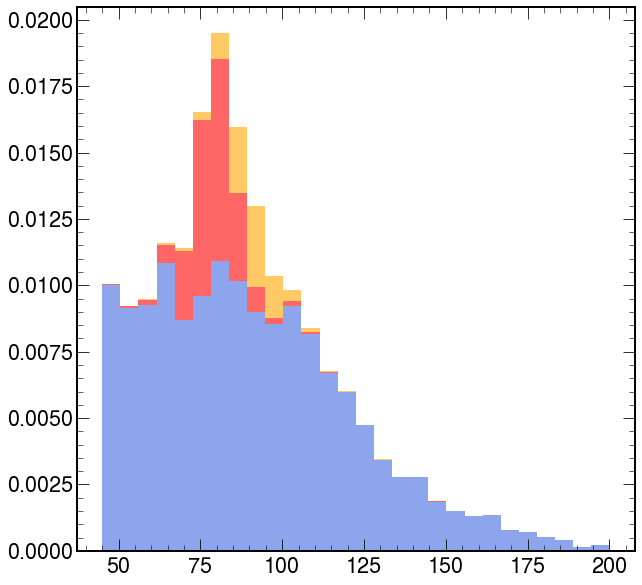

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 142
    # data points      = 28
    # variables        = 9
    chi-square         = 123.933266
    reduced chi-square = 6.52280346
    Akaike info crit   = 59.6510845
    Bayesian info crit = 71.6409251
[[Variables]]
    p0:    -1.3226e-12 +/- 9.5924e-13 (72.53%) (init = -3.343897e-12)
    p1:     7.1184e-10 +/- 6.4116e-10 (90.07%) (init = 2.133232e-09)
    p2:    -1.2565e-07 +/- 1.6598e-07 (132.09%) (init = -5.133544e-07)
    p3:     6.7929e-06 +/- 2.0652e-05 (304.03%) (init = 5.776477e-05)
    p4:     9.0800e-05 +/- 0.00122056 (1344.23%) (init = -0.003111808)
    p5:    -4.7985e-04 +/- 0.02679364 (5583.81%) (init = 0.07536875)
    a:      0.00826650 +/- 0.00111478 (13.49%) (init = 0.005048661)
    mu:     82.1067974 +/- 0.90544094 (1.10%) (init = 80)
    sigma:  6.73127172 +/- 1.08802185 (16.16%) (init = 11.70122)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, 

<Figure size 720x720 with 0 Axes>

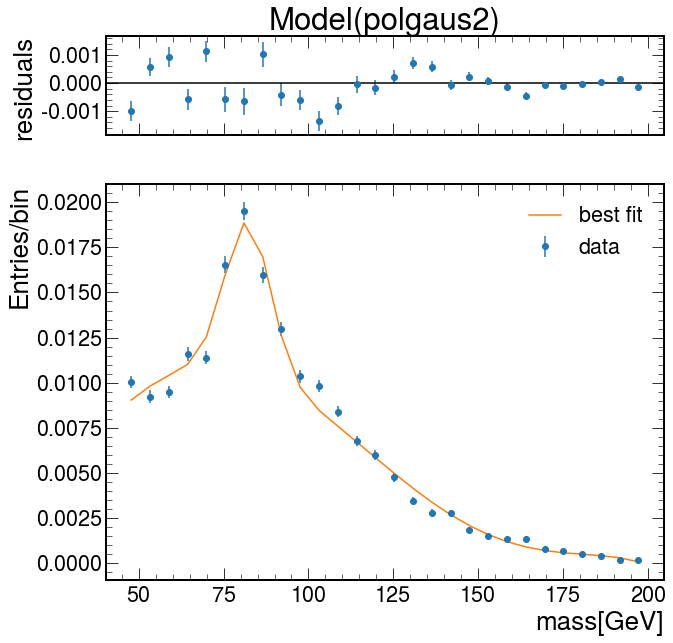

In [18]:
bins=28

# We need the weights from our MC
qcdweights = get_weights(qcd,weights,qcdsel)
wweights = get_weights(wqq13,weights,wsel)*wscale
zweights = get_weights(zqq13,weights,zsel)*zscale

# Now we stack the histograms into a single density 
# so we can fit bkg+signal
counts_mc, bins,_ = plt.hist([qcdW,wW,zW],
                             bins=bins,
                             range=mrange,
                             density=True,
                             stacked=True,
                             color=["royalblue","r", "orange"],
                             alpha=.6,
                             weights= [qcdweights,wweights, zweights])

plt.show()

#The fit process is similar to above, first let's define the model
model = lm.Model(polgaus2,)
p = model.make_params(p0=-3.3438965886446737e-12,
                      p1=2.1332319456288657e-09,
                      p2=-5.133544460851947e-07, 
                      p3=5.776476610767709e-05,
                      p4=-0.0031118077091850833,
                      p5=0.07536875031296641, 
                      a=0.005048661046674717,
                      mu=80,
                      sigma=11.701217273469597, )

#And then obtain the histogram data to fit on
total_weights = sum([sum(weights) for weights in [qcdweights,wweights, zweights]])
counts = counts_mc[-1] #-1 gets the last stack of hists i.e. the total histogram
yvar = counts_mc[-1]/total_weights/np.diff(bins) # we normalize as usual
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

resultW_mc_withZ = model.fit(data=y,
                   params=p,
                   x=x,
                   weights=w,
                   method="leastsq")

#Plot the results
plt.figure()
resultW_mc_withZ.plot()
plt.xlabel("mass[GeV]", position=(0.92,0.1))
plt.ylabel("Entries/bin", position=(0.1,0.84))

print(resultW_mc_withZ.fit_report())

#Obtained the fitted mass
mW_mc_withZ = resultW_mc_withZ.params["mu"].value
mWerr_mc_withZ = resultW_mc_withZ.params["mu"].stderr

## 4.2 MC without Z

Can carry on this step without hints? It's very straight forward

In [ ]:
#### YOUR CODE HERE ####

### Solution

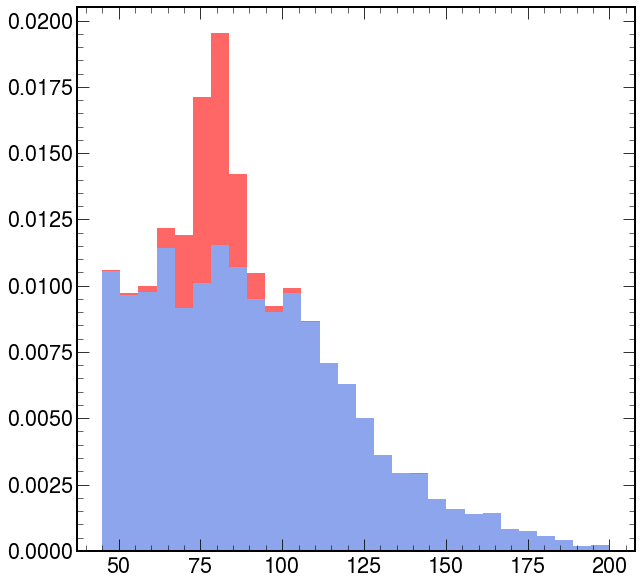

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 28
    # variables        = 9
    chi-square         = 96.4412578
    reduced chi-square = 5.07585567
    Akaike info crit   = 52.6284284
    Bayesian info crit = 64.6182690
[[Variables]]
    p0:    -1.0478e-12 +/- 8.4295e-13 (80.45%) (init = -3.343897e-12)
    p1:     5.3032e-10 +/- 5.5858e-10 (105.33%) (init = 2.133232e-09)
    p2:    -7.9583e-08 +/- 1.4306e-07 (179.77%) (init = -5.133544e-07)
    p3:     1.2507e-06 +/- 1.7577e-05 (1405.39%) (init = 5.776477e-05)
    p4:     3.9730e-04 +/- 0.00102504 (258.00%) (init = -0.003111808)
    p5:    -0.00609215 +/- 0.02229797 (366.01%) (init = 0.07536875)
    a:      0.00871808 +/- 0.00114828 (13.17%) (init = 0.005048661)
    mu:     80.0439332 +/- 0.63890565 (0.80%) (init = 80)
    sigma:  4.67980096 +/- 0.69940906 (14.95%) (init = 11.70122)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p

<Figure size 720x720 with 0 Axes>

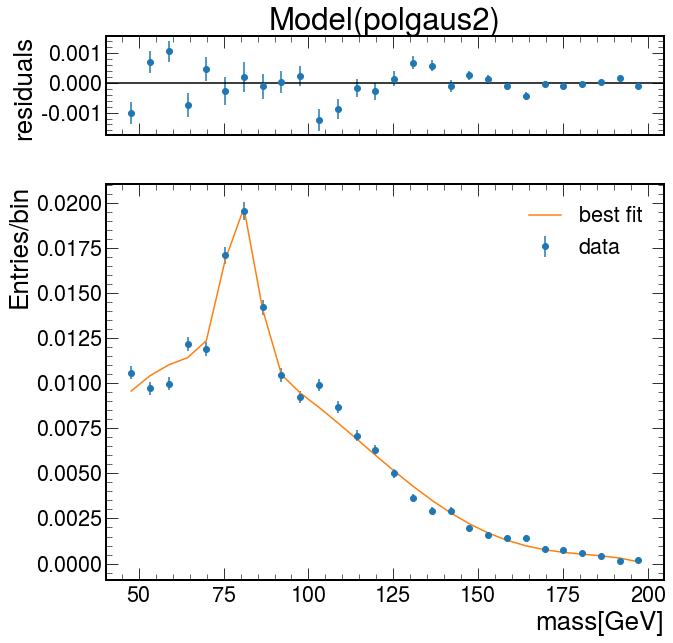

In [19]:
bins=28

# We need the weights from our MC
qcdweights = get_weights(qcd,weights,qcdsel)
wweights =get_weights(wqq13,weights,wsel)*wscale


# Now we stack the histograms into a single density 
# so we can fit bkg+signal
counts_mc, bins,_ = plt.hist([qcdW,wW],
                             bins=bins,
                             range=mrange,
                             density=True,
                             stacked=True,
                             color=["royalblue","r"],
                             alpha=.6,
                             weights= [qcdweights, wweights])
plt.show()

#Obtain the new histogram to fit on
total_weights = sum([sum(weights) for weights in [qcdweights,wweights]])
counts = counts_mc[-1] #-1 gets the last stack of hists i.e. the total histogram
yvar = counts_mc[-1]/total_weights/np.diff(bins) # we normalize as usual
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

#Perform the fit
model = lm.Model(polgaus2,)
p = model.make_params(p0=-3.3438965886446737e-12,
                      p1=2.1332319456288657e-09,
                      p2=-5.133544460851947e-07, 
                      p3=5.776476610767709e-05,
                      p4=-0.0031118077091850833,
                      p5=0.07536875031296641, 
                      a=0.005048661046674717,
                      mu=80,
                      sigma=11.701217273469597,)


resultW_mc_noZ = model.fit(data=y, params=p, x=x, weights=w, method="leastsq")

#Plot the result
plt.figure()
resultW_mc_noZ.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))

print(resultW_mc_noZ.fit_report())

-----

Then we can obtain the mass with no Z in the sample:

In [ ]:
mW_mc_noZ = #### YOUR CODE HERE ####
mWerr_mc_noZ = #### YOUR CODE HERE ####

### Solution

In [ ]:
mW_mc_noZ = resultW_mc_noZ.params["mu"].value
mWerr_mc_noZ = resultW_mc_noZ.params["mu"].stderr

## 4.3 Bias factor and correct for W mass

Now that we obtain the W mass in both cases, let's correct for the W mass!

In [20]:
# now we calculate our bias factor
# if the W mass measured with and without Z is the same 
# this factor should be 1
bias = #### YOUR CODE HERE ####

#propagate the error assuming uncorrelated gaussian uncertainties
bias_err = #### YOUR CODE HERE ####

### Solution

In [20]:
# now we calculate our bias factor
# if the W mass measured with and without Z is the same 
# this factor should be 1
bias = mW_mc_withZ / mW_mc_noZ

#propagate the error assuming uncorrelated gaussian uncertainties
bias_err = np.sqrt((mWerr_mc_noZ*mW_mc_withZ/mW_mc_noZ**2)**2+(mWerr_mc_withZ/mW_mc_noZ)**2)

-----

In [ ]:
mW_corrected = #### YOUR CODE HERE ####
mWerr_corrected = #### YOUR CODE HERE ####

### Solution

In [21]:
mW_corrected = mW/bias
mWerr_corrected = np.sqrt((mWerr/bias)**2 + (bias_err*mW/bias**2)**2)

-----

In [22]:
print(f"Correcting the W mass using MC (simulated data) gives m_W = {mW_corrected:.1f} +\- {mWerr_corrected:.1f}")

Correcting the W mass using MC (simulated data) gives m_W = 80.6 +\- 1.6


If you did everything reasonably, you should get a number similar to this:

$$m_W = 80.6 \pm 1.6$$

In [23]:
sin2theta = 1 - (mW_corrected/mZ)**2
sin2theta_err = #### YOUR CODE HERE ####
print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

sin^2(θ) = 0.222 +\- 0.037


### Solution

In [23]:
sin2theta = 1 - (mW_corrected/mZ)**2
sin2theta_err = np.sqrt((2*mW_corrected*mWerr_corrected/mZ**2)**2 + (2*mW_corrected**2*mZerr/mZ**3)**2)
print(f"sin^2(θ) = {sin2theta:.3f} +\- {sin2theta_err:.3f}")

sin^2(θ) = 0.222 +\- 0.037


-----

And the new $Sin^2(\theta)$ should be at around:

$$Sin^2(\theta) = 0.222 \pm 0.037$$

This measurement is much better than the previous one! Congratulations on making it this far to this lab!

Now if you have made it through this whole exercise, why don't you try to look for the Higgs boson. The Higgs boson also decays hadronically and decays predominantly to a certainy pair of particles. Take a look [here](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-higgs-boson.pdf). 
 <font color="blue"> Can you search for the Higgs boson? What is your sensitivity.  </font>

------

## 4. Search for the Higgs Boson! (OPTIONAL)